In [1]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cv2
from tensorflow.keras.callbacks import EarlyStopping

# Convolutional Neural network

### Reading the dataset

In [2]:
path = r"C:\Users\AAA\Desktop\Projects and Researchs\Chapter_Gel\segmented"

In [3]:
labels = ["Adino", "SCC", "SIL"]

In [4]:
image_data,label_data = [],[]
print("start reading")
for l in labels:
    data_path = os.path.join(path,l)
    for f in os.listdir(data_path):
        image = cv2.imread(os.path.join(data_path, f))
        image = cv2.resize(image, (144,144))
        image_data.append(image)
        label_data.append(labels.index(l)) ## only taking index of the label (Eg. 1 for Normal, 2 for Precancer ...)
print("Finished")

start reading
Finished


### Displaying sample images

In [5]:
image_data = np.array(image_data)

In [6]:
label_data = np.array(label_data)

In [7]:
sample_image = image_data[1]
sample_image_label = label_data[1]

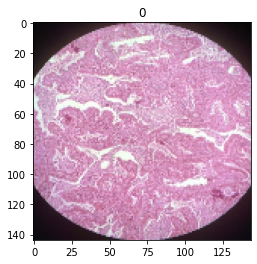

In [8]:
plt.imshow(sample_image, cmap='gray')
plt.title(sample_image_label)
plt.show()

In [9]:
## Spliting the dataset into train and validation
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
    
# train_rows=len(X_train)
# X_train = X_train.reshape(train_rows,-1)
# (80,30000)

image_data_rows=len(image_data)
image_data_reshaped = image_data.reshape(image_data_rows,-1)


sm_image_data, sm_label_data = sm.fit_resample(image_data_reshaped, label_data)
sm_image_data = sm_image_data.reshape(-1,144,144,3)


In [10]:
sm_image_data.shape

(774, 144, 144, 3)

In [11]:
import pandas as pd

label_df = pd.DataFrame(sm_label_data)
label_df.groupby(0).size()

0
0    258
1    258
2    258
dtype: int64

In [12]:
train_x, val_x, train_y, val_y = train_test_split(sm_image_data, sm_label_data, test_size = 0.3, shuffle = True)

In [13]:
train_x.shape

(541, 144, 144, 3)

In [14]:
val_x.shape

(233, 144, 144, 3)

In [ ]:
## converting the label into catregorical (One hote encoding)

In [15]:
train_y_cat = to_categorical(train_y, num_classes = 3)
val_y_cat = to_categorical(val_y, num_classes = 3)

#### Building CNN model

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import l2

In [29]:
def first_cnn():
    model = Sequential()
    model.add(Conv2D(512, (3,3), activation = 'relu', input_shape=(144,144,3)))
    model.add(Conv2D(256, (3,3), activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3,3), activation ='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(3, activation = 'softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])
    return model

In [30]:
model = first_cnn()

In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 142, 142, 512)     14336     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 140, 140, 256)     1179904   
_________________________________________________________________
dropout_5 (Dropout)          (None, 140, 140, 256)     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 138, 138, 256)     590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 69, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1218816)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [32]:
## early stopping mechanism
es = EarlyStopping(monitor ='val_accuracy', mode = 'max', patience = 10)

In [ ]:
history = model.fit(train_x, train_y_cat, epochs = 300, batch_size = 32, validation_data = (val_x, val_y_cat), callbacks = [es])

Epoch 1/300
17/17 [==============================] - 724s 43s/step - loss: 1841.4281 - accuracy: 0.3438 - val_loss: 11.0410 - val_accuracy: 0.4807
Epoch 2/300
17/17 [==============================] - 747s 44s/step - loss: 10.3842 - accuracy: 0.5582 - val_loss: 3.5951 - val_accuracy: 0.6395
Epoch 3/300
17/17 [==============================] - 750s 44s/step - loss: 3.1502 - accuracy: 0.6396 - val_loss: 1.8048 - val_accuracy: 0.6824
Epoch 4/300
17/17 [==============================] - 766s 45s/step - loss: 2.6573 - accuracy: 0.6932 - val_loss: 2.1832 - val_accuracy: 0.6438
Epoch 5/300
17/17 [==============================] - 783s 46s/step - loss: 1.3434 - accuracy: 0.8226 - val_loss: 1.4706 - val_accuracy: 0.6524
Epoch 6/300
17/17 [==============================] - 758s 45s/step - loss: 1.1923 - accuracy: 0.8410 - val_loss: 1.5513 - val_accuracy: 0.6223
Epoch 7/300
17/17 [==============================] - 750s 44s/step - loss: 1.1386 - accuracy: 0.8835 - val_loss: 1.5652 - val_accuracy: 0

In [21]:
import json
hst = open(r"C:\Users\user\Desktop\chapter_geletaw\Newdata/firstcnnmodel_hist.json", 'w')
json.dump(history.history, hst)

In [23]:
model.save_weights(r"C:\Users\user\Desktop\chapter_geletaw\Newdata/firstcnnmodel.h5")

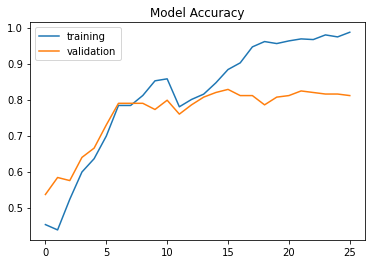

In [31]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label = 'training')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()
plt.show()

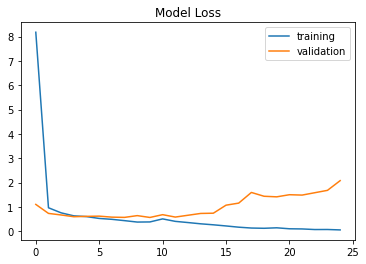

In [32]:
plt.title('Model Loss')
plt.plot(history.history['loss'][1:], label = 'training')
plt.plot(history.history['val_loss'][1:], label = 'validation')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(val_x)

In [34]:
y_pred[0]

array([9.9637407e-01, 8.2165276e-04, 2.8041841e-03], dtype=float32)

In [35]:
y_pred_single = []
for i in y_pred:
    y_pred_single.append(np.argmax(i))

In [36]:
y_pred_single[0]

0

In [37]:
val_y[0]

0

In [38]:
y_pred.shape

(233, 3)

In [39]:
label_data.shape

(465,)

In [40]:
import pandas as pd
label_df = pd.DataFrame(y_pred_single)
label_df.groupby(0).size()

0
0    93
1    73
2    67
dtype: int64

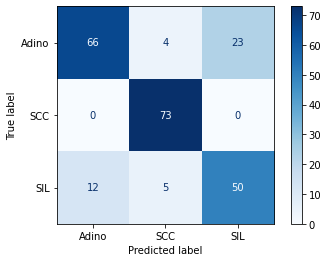

In [41]:
 
cm = confusion_matrix(y_pred_single,val_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()